In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt 
import math
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm
pd.set_option('display.max_columns', None)
from sklearn import preprocessing
import itertools

import time
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

from scipy import stats
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
from statsmodels.stats.outliers_influence import variance_inflation_factor

from statsmodels.formula.api import wls

# Data Cleaning

In [2]:
houseprice=pd.read_csv('/Users/jingxianli/Downloads/housedata/data.csv')
houseprice

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


In [3]:
#Checking for missing value
houseprice.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [4]:
#Checking for missing value
houseprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
date             4600 non-null object
price            4600 non-null float64
bedrooms         4600 non-null float64
bathrooms        4600 non-null float64
sqft_living      4600 non-null int64
sqft_lot         4600 non-null int64
floors           4600 non-null float64
waterfront       4600 non-null int64
view             4600 non-null int64
condition        4600 non-null int64
sqft_above       4600 non-null int64
sqft_basement    4600 non-null int64
yr_built         4600 non-null int64
yr_renovated     4600 non-null int64
street           4600 non-null object
city             4600 non-null object
statezip         4600 non-null object
country          4600 non-null object
dtypes: float64(4), int64(9), object(5)
memory usage: 647.0+ KB


In [5]:
#Data preprocessing
housepriceC = houseprice.copy()
housepriceC = housepriceC.loc[housepriceC.city == 'Seattle']
housepriceC.loc[housepriceC.yr_renovated == 0, 'renovated_pro'] = housepriceC.yr_built
housepriceC.loc[housepriceC.yr_renovated != 0, 'renovated_pro'] = housepriceC.yr_renovated
housepriceC['built_age'] = 2014 - housepriceC.yr_built
housepriceC['renovated_age'] = 2014 - housepriceC.renovated_pro


statezip = housepriceC['statezip']
housepriceC.drop('date', axis=1, inplace=True)
housepriceC.drop('street', axis=1, inplace=True)
housepriceC.drop('statezip', axis=1, inplace=True)
housepriceC.drop('country', axis=1, inplace=True)
housepriceC.drop('city', axis=1, inplace=True)
housepriceC.drop('yr_built', axis=1, inplace=True)
housepriceC.drop('renovated_pro', axis=1, inplace=True)
housepriceC.drop('yr_renovated', axis=1, inplace=True)
# housepriceC['statezip'] = statezip

housepriceC['price'] = housepriceC['price'].astype(int)

housepriceC = housepriceC.reset_index()


# Visualization

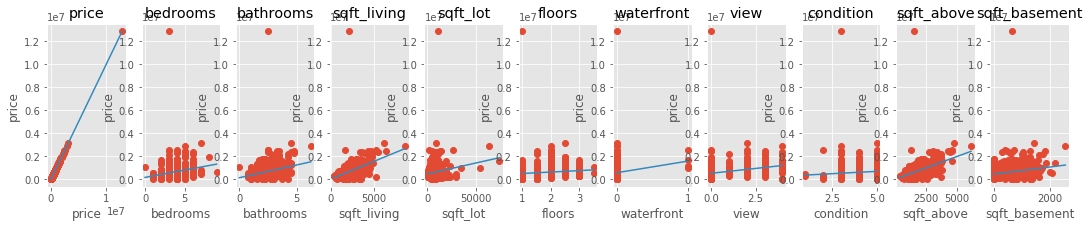

In [6]:
#scatter plot
plt.figure(figsize=(20, 3))


# i: index
for i, col in enumerate(housepriceC.columns[1:12]):
    plt.subplot(1, 12, i+1)
    x = housepriceC[col]
    y = housepriceC['price']
    plt.plot(x, y, 'o')
#     Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price')

(14.0, 0.0)

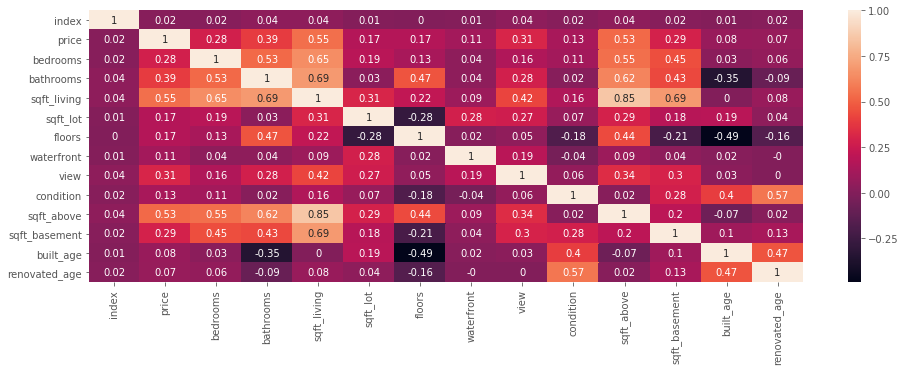

In [7]:
#correlation
import seaborn as sns
correlation_matrix = housepriceC.corr().round(2)
# annot = True to print the values inside the square
plt.figure(figsize = (16,5))
heatmap = sns.heatmap(data=correlation_matrix, annot=True)
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)

# Modeling

## Fit linear model using all predictors

In [8]:
#now we can fit mlr
fit_all = smf.ols('price~bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+sqft_above+sqft_basement+built_age+renovated_age',data=housepriceC).fit()

In [9]:
fit_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     75.88
Date:                Sun, 13 Oct 2019   Prob (F-statistic):          1.13e-136
Time:                        23:57:58   Log-Likelihood:                -22414.
No. Observations:                1573   AIC:                         4.485e+04
Df Residuals:                    1561   BIC:                         4.492e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.473e+05   6.89e+04     -2.137      0.033   -2.82e+05   -1.21e+04
bedrooms      -6.378e+04   1.28e+04     -4.984      0.000   -8.89e+04   -3.87e+04
bathrooms      5.028e+04   2.01e+04      2.499      0.013    1.08e+04    8.97e+04
sqft_living     186.6921     13.966     13.368      0.000     159.299     214.086
sqft_lot         -5.0517      2.893     -1.746      0.081     -10.726       0.622
floors         7703.4543   2.46e+04      0.313      0.754   -4.05e+04    5.59e+04
waterfront     5.171e+05   1.99e+05      2.599      0.009    1.27e+05    9.07e+05
view           4.186e+04   1.28e+04      3.259      0.001    1.67e+04    6.71e+04
condition      3.669e+04   1.62e+04      2.261      0.024    4863.516    6.85e+04
sqft_above      189.7193     18.739     10.124      0.000     152.962     226.476
sqft_basement    -3.0272     20.836     -0.145      0.885     -43.897      37.843
built_age      1732.1039    380.087      4.557      0.000     986.569    2477.639
renovated_age  -473.8032    356.572     -1.329      0.184   -1173.215     225.608
==============================================================================
Omnibus:                     3718.734   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         35674914.911
Skew:                          22.536   Prob(JB):                         0.00
Kurtosis:                     739.395   Cond. No.                     4.77e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.45e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Residual checking

35674914.91100815 0.0 22.536149699709625 739.3948837433973


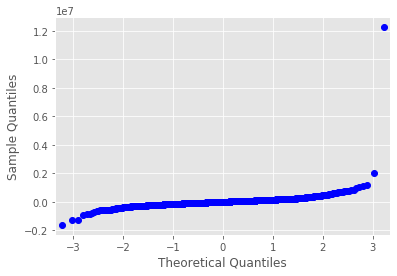

In [10]:
#2. check residual 
#2.1 Normality
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(fit_all.resid)
print(JB,JBpv,skw,kurt)

sm.qqplot(fit_all.resid)

plt.show()

Text(0.5, 1.0, 'Fitted Values vs. Residuals')

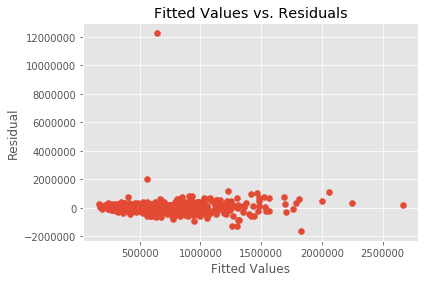

In [11]:
#2.2 Fitted Values vs. Residuals
p = fit_all.fittedvalues.astype(int)
res = fit_all.resid.astype(int)
# plt.scatter(p,res)
# plt.xlabel("Fitted Values")
# plt.ylabel("Residual")
# plt.title("Fitted Values vs. Residuals")

fig, ax = plt.subplots()
ax.scatter(p, res)
ax.ticklabel_format(style='plain')
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

#nonlinearity

## Multiple ways to check influential points

In [12]:
#influential points
#object for the analysis of influential points
infl = fit_all.get_influence()

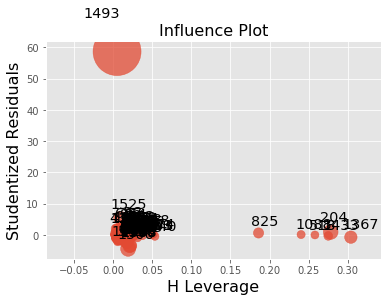

In [13]:
#graphical representation of the influences()
sm.graphics.influence_plot(fit_all)
plt.show()

In [14]:
#Internal
#threshold leverage
residus = fit_all.resid.as_matrix() #residuals
leviers = infl.hat_matrix_diag  #leverage
n = housepriceC.shape[0]
p=13
seuil_levier = 3*p/n # people choose 2.5 or 3 as well
print(seuil_levier)
#identification
atyp_levier = leviers > seuil_levier
print(atyp_levier)

0.024793388429752067
[False False False ... False False False]


/Users/jingxianli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
print(housepriceC.index[atyp_levier],leviers[atyp_levier])


Int64Index([  84,  174,  204,  251,  492,  518,  537,  544,  552,  825,  831,
             840, 1088, 1118, 1163, 1345, 1367, 1433],
           dtype='int64') [0.0309722  0.05121955 0.2782304  0.0482978  0.02906519 0.25805939
 0.02508913 0.02651261 0.02833862 0.18589591 0.02770645 0.0532016
 0.24034618 0.03409378 0.03748904 0.02626907 0.30403383 0.27509227]


In [16]:
#threshold externally studentized residuals
import scipy
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)

#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
#which ones?
print(housepriceC.index[atyp_stud],reg_studs[atyp_stud])

Int64Index([   0,   86,  368,  415,  541,  552,  667,  964, 1312, 1357, 1362,
            1372, 1493, 1506, 1508, 1519, 1525, 1555, 1558],
           dtype='int64') [ 2.61607532  3.0787401  -2.24346402  2.06810715 -2.36887973  2.0655439
  3.15580938  2.7258973   2.09241141  2.20379577  2.07712388  2.21945532
 58.68100739 -4.42072415 -3.53067406 -2.07801883  5.42054364 -3.41056095
 -2.54546553]


In [17]:
#DFFITS for detecting influential points
inflsum=infl.summary_frame()
reg_dffits=inflsum.dffits
seuil_dffits=2*np.sqrt((p+1)/(n-p-1))
atyp_dffits = np.abs(reg_dffits) > seuil_dffits
print(housepriceC.index[atyp_dffits],reg_dffits[atyp_dffits])

Int64Index([   0,   86,  203,  204,  353,  360,  368,  537,  541,  552,  667,
             802,  825,  839,  964,  988, 1048, 1118, 1166, 1312, 1357, 1367,
            1400, 1434, 1493, 1506, 1508, 1525, 1555, 1558],
           dtype='int64') 0       0.410377
86      0.484658
203    -0.198873
204     0.596143
353     0.210147
360    -0.229705
368    -0.316619
537     0.290597
541    -0.289191
552     0.352749
667     0.354663
802    -0.205265
825     0.309191
839     0.219998
964     0.361460
988    -0.219176
1048    0.248932
1118    0.235987
1166   -0.205333
1312    0.284476
1357    0.200725
1367   -0.460475
1400    0.195706
1434    0.268863
1493    4.078461
1506   -0.615139
1508   -0.515254
1525    0.517357
1555   -0.506973
1558   -0.338820
Name: dffits, dtype: float64


In [18]:
#Using hat matrix to identify the outliers
hat_mat = infl.hat_matrix_diag
threshold = 3*p/n
out_liers_hat = []
for i,h in enumerate(hat_mat):
    if h > threshold:
        out_liers_hat.append(i)
out_liers_hat

[84,
 174,
 204,
 251,
 492,
 518,
 537,
 544,
 552,
 825,
 831,
 840,
 1088,
 1118,
 1163,
 1345,
 1367,
 1433]

In [19]:
#Cooks for detecting influential points
inflsum=infl.summary_frame()
reg_cooks_d=inflsum.cooks_d
seuil_cooks= 4/(n-p)
atyp_cooks = np.abs(reg_cooks_d) > seuil_cooks
print(housepriceC.index[atyp_cooks],reg_cooks_d[atyp_cooks])

Int64Index([   0,   86,  203,  204,  353,  360,  368,  537,  541,  552,  667,
             802,  825,  839,  904,  964,  988, 1048, 1118, 1166, 1312, 1357,
            1367, 1400, 1434, 1493, 1506, 1508, 1525, 1555, 1558],
           dtype='int64') 0       0.012906
86      0.017971
203     0.003041
204     0.027339
353     0.003392
360     0.004052
368     0.007691
537     0.006486
541     0.006414
552     0.009552
667     0.009621
802     0.003238
825     0.007357
839     0.003717
904     0.002705
964     0.010009
988     0.003692
1048    0.004762
1118    0.004282
1166    0.003240
1312    0.006212
1357    0.003092
1367    0.016316
1400    0.002943
1434    0.005552
1493    0.399192
1506    0.028766
1508    0.020273
1525    0.020221
1555    0.019637
1558    0.008800
Name: cooks_d, dtype: float64


In [20]:
#suspicious observations with one of the two criteria
pbm_infl = np.logical_or(atyp_levier,atyp_stud)
out_liers_index = list(housepriceC.index[pbm_infl])
out_liers_index.extend(list(housepriceC.index[atyp_cooks]))
out_liers_index.extend(out_liers_hat)
out_liers_index = list(set(out_liers_index))
out_liers_index

[0,
 518,
 904,
 1163,
 1166,
 1555,
 1558,
 1048,
 537,
 1433,
 667,
 1434,
 541,
 415,
 544,
 1312,
 802,
 552,
 174,
 825,
 831,
 1088,
 1345,
 964,
 839,
 840,
 203,
 204,
 1357,
 1362,
 84,
 1493,
 86,
 1367,
 1372,
 988,
 1118,
 353,
 1506,
 1508,
 360,
 492,
 1519,
 368,
 1525,
 1400,
 251]

In [21]:
# # Delete row with index label outliers 
housepriceC = housepriceC.drop(housepriceC.index[out_liers_index])

In [22]:
housepriceC = housepriceC.drop(columns=['index'])

## Model selection

### Best subset selection

In [23]:
#Model Selection
#Helper function for fitting linear regression (Sklearn)
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [24]:
#Implementing Best subset selection (using itertools.combinations)
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

#Initialization variables
Y = housepriceC.price
X = housepriceC.drop(columns = 'price', axis = 1)
k = 12
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 12 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [25]:
#Finding the best subsets for each number of features¶
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min)
display(df_max)

,numb_features,RSS,R_squared,features
2,1,5.537360e+13,0.522256,"(sqft_living,)"
39,2,5.226082e+13,0.549112,"(sqft_living, sqft_basement)"
191,3,4.863913e+13,0.580358,"(sqft_living, floors, built_age)"
620,4,4.608045e+13,0.602434,"(sqft_living, floors, view, built_age)"
1374,5,4.321288e+13,0.627174,"(sqft_living, sqft_lot, view, sqft_above, buil..."
1376,5,4.321288e+13,0.627174,"(sqft_living, sqft_lot, view, sqft_basement, b..."
1520,5,4.321288e+13,0.627174,"(sqft_lot, view, sqft_above, sqft_basement, bu..."
1836,6,4.191392e+13,0.638381,"(bedrooms, sqft_living, sqft_lot, view, sqft_a..."
1838,6,4.191392e+13,0.638381,"(bedrooms, sqft_living, sqft_lot, view, sqft_b..."
1982,6,4.191392e+13,0.638381,"(bedrooms, sqft_lot, view, sqft_above, sqft_ba..."


,numb_features,RSS,R_squared,features
2,1,5.537360e+13,0.522256,"(sqft_living,)"
38,2,5.226082e+13,0.549112,"(sqft_living, sqft_above)"
39,2,5.226082e+13,0.549112,"(sqft_living, sqft_basement)"
72,2,5.226082e+13,0.549112,"(sqft_above, sqft_basement)"
191,3,4.863913e+13,0.580358,"(sqft_living, floors, built_age)"
620,4,4.608045e+13,0.602434,"(sqft_living, floors, view, built_age)"
1374,5,4.321288e+13,0.627174,"(sqft_living, sqft_lot, view, sqft_above, buil..."
1376,5,4.321288e+13,0.627174,"(sqft_living, sqft_lot, view, sqft_basement, b..."
1520,5,4.321288e+13,0.627174,"(sqft_lot, view, sqft_above, sqft_basement, bu..."
1836,6,4.191392e+13,0.638381,"(bedrooms, sqft_living, sqft_lot, view, sqft_a..."


In [26]:
#Adding columns to the dataframe with RSS and R squared values of the best subset
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)

In [27]:
#Find the best model for each number of predictors based on RSS and R_Squarded
df2 = df.loc[(df.numb_features == 1) & (df.R_squared == df.max_R_squared)]
for i in range(0,13):
    df2 = pd.concat([df2, df.loc[(df.numb_features == i) & (df.R_squared == df.max_R_squared)]], axis=0)

In [28]:
df2

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
2,1,5.537360e+13,0.522256,"(sqft_living,)",5.537360e+13,0.522256
2,1,5.537360e+13,0.522256,"(sqft_living,)",5.537360e+13,0.522256
38,2,5.226082e+13,0.549112,"(sqft_living, sqft_above)",5.226082e+13,0.549112
39,2,5.226082e+13,0.549112,"(sqft_living, sqft_basement)",5.226082e+13,0.549112
72,2,5.226082e+13,0.549112,"(sqft_above, sqft_basement)",5.226082e+13,0.549112
191,3,4.863913e+13,0.580358,"(sqft_living, floors, built_age)",4.863913e+13,0.580358
620,4,4.608045e+13,0.602434,"(sqft_living, floors, view, built_age)",4.608045e+13,0.602434
1374,5,4.321288e+13,0.627174,"(sqft_living, sqft_lot, view, sqft_above, buil...",4.321288e+13,0.627174
1376,5,4.321288e+13,0.627174,"(sqft_living, sqft_lot, view, sqft_basement, b...",4.321288e+13,0.627174
1520,5,4.321288e+13,0.627174,"(sqft_lot, view, sqft_above, sqft_basement, bu...",4.321288e+13,0.627174


In [29]:
#Computing C_P AIC BIC R_adj
m = len(Y)
p = 12
hat_sigma_squared = (1/(m - p -1)) * min(df2['RSS'])

df2['C_p'] = (1/m) * (df2['RSS'] + 2 * df2['numb_features'] * hat_sigma_squared )
df2['AIC'] = (1/(m*hat_sigma_squared)) * (df2['RSS'] + 2 * df2['numb_features'] * hat_sigma_squared )
df2['BIC'] = (1/(m*hat_sigma_squared)) * (df2['RSS'] +  np.log(m) * df2['numb_features'] * hat_sigma_squared )
df2['R_squared_adj'] = 1 - ( (1 - df2['R_squared'])*(m-1)/(m-df2['numb_features'] -1))
df2['C_p'] = df2.C_p.astype(int)
df2['RSS'] = df2.RSS.astype(int)
# df2['index'] = range(len(df2))
df2['index'] = range(len(df2))
df2

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared,C_p,AIC,BIC,R_squared_adj,index
2,1,55373604054273,0.522256,"(sqft_living,)",5.537360e+13,0.522256,36321770150,1.359928,1.363421,0.521942,0
2,1,55373604054273,0.522256,"(sqft_living,)",5.537360e+13,0.522256,36321770150,1.359928,1.363421,0.521942,1
38,2,52260820828020,0.549112,"(sqft_living, sqft_above)",5.226082e+13,0.549112,34316943131,1.284865,1.291851,0.548520,2
39,2,52260820828020,0.549112,"(sqft_living, sqft_basement)",5.226082e+13,0.549112,34316943131,1.284865,1.291851,0.548520,3
72,2,52260820828020,0.549112,"(sqft_above, sqft_basement)",5.226082e+13,0.549112,34316943131,1.284865,1.291851,0.548520,4
191,3,48639132352971,0.580358,"(sqft_living, floors, built_age)",4.863913e+13,0.580358,31978626433,1.197316,1.207795,0.579531,5
620,4,46080449127535,0.602434,"(sqft_living, floors, view, built_age)",4.608045e+13,0.602434,30336905575,1.135848,1.149820,0.601388,6
1374,5,43212883382895,0.627174,"(sqft_living, sqft_lot, view, sqft_above, buil...",4.321288e+13,0.627174,28492771532,1.066801,1.084267,0.625948,7
1376,5,43212883382895,0.627174,"(sqft_living, sqft_lot, view, sqft_basement, b...",4.321288e+13,0.627174,28492771532,1.066801,1.084267,0.625948,8
1520,5,43212883382895,0.627174,"(sqft_lot, view, sqft_above, sqft_basement, bu...",4.321288e+13,0.627174,28492771532,1.066801,1.084267,0.625948,9


In [30]:
#Model selected by C_p
model_C_p = df2.sort_values(by=['C_p'], ascending = True).head(5)
model_C_p
#Cp: 20 19 18 21 17

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared,C_p,AIC,BIC,R_squared_adj,index
4058,10,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_lot, floors, view, ...",4.041011e+13,0.651356,26831114026,1.004587,1.039518,0.649054,23
4034,10,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_living, sqft_lot, f...",4.041011e+13,0.651356,26831114026,1.004587,1.039518,0.649054,22
4033,10,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_living, sqft_lot, f...",4.041011e+13,0.651356,26831114026,1.004587,1.039518,0.649054,21
3907,9,40485359090426,0.650706,"(bedrooms, bathrooms, sqft_lot, view, conditio...",4.048536e+13,0.650706,26845421917,1.005123,1.036560,0.648633,20
3849,9,40485359090426,0.650706,"(bedrooms, bathrooms, sqft_living, sqft_lot, v...",4.048536e+13,0.650706,26845421917,1.005123,1.036560,0.648633,19


In [31]:
#Model selected by AIC
model_AIC = df2.sort_values(by=['AIC'], ascending = True).head(5)
model_AIC
#AIC 20 19 18 21 17

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared,C_p,AIC,BIC,R_squared_adj,index
4058,10,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_lot, floors, view, ...",4.041011e+13,0.651356,26831114026,1.004587,1.039518,0.649054,23
4034,10,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_living, sqft_lot, f...",4.041011e+13,0.651356,26831114026,1.004587,1.039518,0.649054,22
4033,10,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_living, sqft_lot, f...",4.041011e+13,0.651356,26831114026,1.004587,1.039518,0.649054,21
3907,9,40485359090426,0.650706,"(bedrooms, bathrooms, sqft_lot, view, conditio...",4.048536e+13,0.650706,26845421917,1.005123,1.036560,0.648633,20
3849,9,40485359090426,0.650706,"(bedrooms, bathrooms, sqft_living, sqft_lot, v...",4.048536e+13,0.650706,26845421917,1.005123,1.036560,0.648633,19


In [32]:
#Model selected by BIC
model_BIC = df2.sort_values(by=['BIC'], ascending = True).head(5)
model_BIC

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared,C_p,AIC,BIC,R_squared_adj,index
3907,9,40485359090426,0.650706,"(bedrooms, bathrooms, sqft_lot, view, conditio...",4.048536e+13,0.650706,26845421917,1.005123,1.036560,0.648633,20
3849,9,40485359090426,0.650706,"(bedrooms, bathrooms, sqft_living, sqft_lot, v...",4.048536e+13,0.650706,26845421917,1.005123,1.036560,0.648633,19
3848,9,40485359090426,0.650706,"(bedrooms, bathrooms, sqft_living, sqft_lot, v...",4.048536e+13,0.650706,26845421917,1.005123,1.036560,0.648633,18
3477,8,40704567934301,0.648815,"(bedrooms, bathrooms, sqft_lot, view, conditio...",4.070457e+13,0.648815,26954066510,1.009191,1.037135,0.646963,17
3359,8,40704567934301,0.648815,"(bedrooms, bathrooms, sqft_living, sqft_lot, v...",4.070457e+13,0.648815,26954066510,1.009191,1.037135,0.646963,16


In [33]:
#Model selected by R_adj
model_R_squared_adj = df2.sort_values(by=['R_squared_adj'], ascending = False).head(5)
model_R_squared_adj

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared,C_p,AIC,BIC,R_squared_adj,index
4058,10,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_lot, floors, view, ...",4.041011e+13,0.651356,26831114026,1.004587,1.039518,0.649054,23
4034,10,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_living, sqft_lot, f...",4.041011e+13,0.651356,26831114026,1.004587,1.039518,0.649054,22
4033,10,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_living, sqft_lot, f...",4.041011e+13,0.651356,26831114026,1.004587,1.039518,0.649054,21
4091,11,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_lot, floors, waterf...",4.041011e+13,0.651356,26866118741,1.005898,1.044321,0.648823,27
4088,11,40410108053829,0.651356,"(bedrooms, bathrooms, sqft_living, sqft_lot, f...",4.041011e+13,0.651356,26866118741,1.005898,1.044321,0.648823,26


In [34]:
model_BIC.head(1)

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared,C_p,AIC,BIC,R_squared_adj,index
3907,9,40485359090426,0.650706,"(bedrooms, bathrooms, sqft_lot, view, conditio...",4.048536e+13,0.650706,26845421917,1.005123,1.03656,0.648633,20


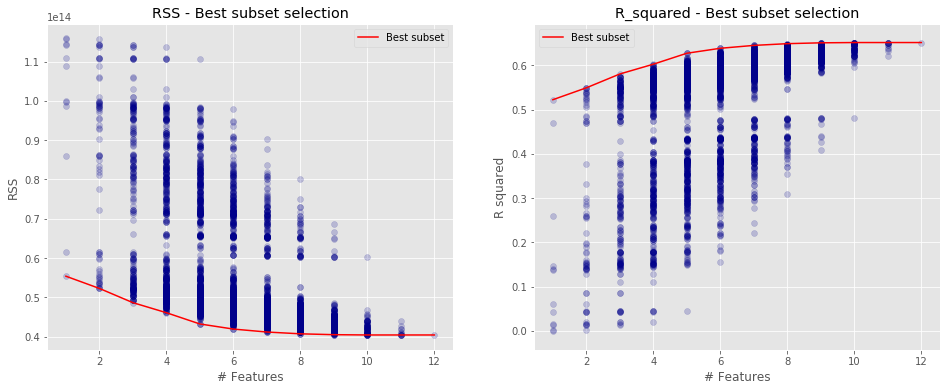

In [36]:
#Plotting the best subset selection process
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

## Forward selection

In [37]:
#Forward
#Initialization variables
Y = housepriceC.price
X = housepriceC.drop(columns = 'price', axis = 1)
k = 12

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [38]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,13)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['sqft_living'], 55373604054274.0),
 (2, ['sqft_living', 'sqft_above'], 52260820828021.0),
 (3, ['sqft_living', 'sqft_above', 'built_age'], 49407837919707.0),
 (4, ['sqft_living', 'sqft_above', 'built_age', 'sqft_lot'], 46225100861872.0),
 (5,
  ['sqft_living', 'sqft_above', 'built_age', 'sqft_lot', 'view'],
  43212883382895.0),
 (6,
  ['sqft_living', 'sqft_above', 'built_age', 'sqft_lot', 'view', 'bedrooms'],
  41913916567245.0),
 (7,
  ['sqft_living',
   'sqft_above',
   'built_age',
   'sqft_lot',
   'view',
   'bedrooms',
   'bathrooms'],
  41160810764307.0),
 (8,
  ['sqft_living',
   'sqft_above',
   'built_age',
   'sqft_lot',
   'view',
   'bedrooms',
   'bathrooms',
   'condition'],
  40704567934301.0),
 (9,
  ['sqft_living',
   'sqft_above',
   'built_age',
   'sqft_lot',
   'view',
   'bedrooms',
   'bathrooms',
   'condition',
   'renovated_age'],
  40485359090426.0),
 (10,
  ['sqft_living',
   'sqft_above',
   'built_age',
   'sqft_lot',
   'view',
   'bedrooms',
   'b

In [39]:
#Combining forward stepwise results into a new DataFrame¶
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [40]:
#Computing the C_p, AIC, BIC and R-square adjusted¶
#Initializing useful variables
m = len(Y)
p = 12
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1['C_p'] = df1.C_p.astype(int)
df1['RSS'] = df1.RSS.astype(int)
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[sqft_living],55373604054273,0.522256,1,36321770150,1.359928,1.363421,0.521942
2,"[sqft_living, sqft_above]",52260820828020,0.549112,2,34316943131,1.284865,1.291851,0.548520
3,"[sqft_living, sqft_above, built_age]",49407837919706,0.573726,3,32482365337,1.216176,1.226656,0.572886
4,"[sqft_living, sqft_above, built_age, sqft_lot]",46225100861872,0.601186,4,30431697013,1.139397,1.153369,0.600137
5,"[sqft_living, sqft_above, built_age, sqft_lot,...",43212883382895,0.627174,5,28492771532,1.066801,1.084267,0.625948
6,"[sqft_living, sqft_above, built_age, sqft_lot,...",41913916567245,0.638381,6,27676552907,1.036241,1.057200,0.636953
7,"[sqft_living, sqft_above, built_age, sqft_lot,...",41160810764306,0.644879,7,27218041369,1.019074,1.043526,0.643241
8,"[sqft_living, sqft_above, built_age, sqft_lot,...",40704567934301,0.648815,8,26954066510,1.009191,1.037135,0.646963
9,"[sqft_living, sqft_above, built_age, sqft_lot,...",40485359090426,0.650706,9,26845421917,1.005123,1.036560,0.648633
10,"[sqft_living, sqft_above, built_age, sqft_lot,...",40410108053829,0.651356,10,26831114026,1.004587,1.039518,0.649054


## Fit selected model and residual analysis

### Forward selection's best model

In [42]:
fit_for_sub = smf.ols('price~sqft_living+sqft_above+built_age+sqft_lot+view+bedrooms+bathrooms+condition+renovated_age',data=housepriceC).fit()
fit_for_sub.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     313.8
Date:                Sun, 13 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:58:14   Log-Likelihood:                -20478.
No. Observations:                1526   AIC:                         4.098e+04
Df Residuals:                    1516   BIC:                         4.103e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.025e+05   2.81e+04     -3.641      0.000   -1.58e+05   -4.73e+04
sqft_living     159.3758     12.935     12.322      0.000     134.004     184.748
sqft_above      187.1158     14.001     13.365      0.000     159.653     214.578
built_age      1893.6752    161.877     11.698      0.000    1576.149    2211.201
sqft_lot        -15.1546      1.622     -9.341      0.000     -18.337     -11.972
view           5.662e+04   6043.432      9.369      0.000    4.48e+04    6.85e+04
bedrooms      -4.605e+04   5961.664     -7.724      0.000   -5.77e+04   -3.44e+04
bathrooms      4.388e+04   8915.182      4.922      0.000    2.64e+04    6.14e+04
condition      3.663e+04   7326.051      4.999      0.000    2.23e+04     5.1e+04
renovated_age  -456.4847    159.330     -2.865      0.004    -769.015    -143.955
==============================================================================
Omnibus:                       77.780   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.959
Skew:                           0.235   Prob(JB):                     1.55e-46
Kurtosis:                       4.760   Cond. No.                     4.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

210.95905627027705 1.5517543701623546e-46 0.23482223836938262 4.759906194329343


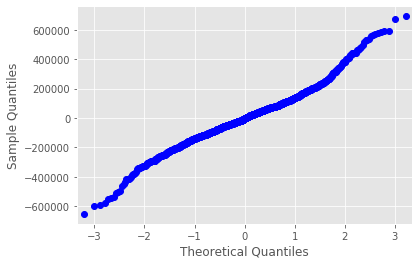

In [43]:
#2. check residual 
#2.1 Normality
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(fit_for_sub.resid)
print(JB,JBpv,skw,kurt)

sm.qqplot(fit_for_sub.resid)

plt.show()

In [44]:
#Breusch-Pagan for Heteroskedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
#from statsmodels.stats.diagnostic import het_white
#white_test = het_white(reg.resid,  reg.model.exog)
bp_test = het_breuschpagan(fit_for_sub.resid, fit_for_sub.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 245.69779101234948, 'LM-Test p-value': 8.072455576263355e-48, 'F-Statistic': 32.32551472439242, 'F-Test p-value': 2.8886096297892576e-52}


In [45]:
from statistics import mean 
# (fit12_new.resid).mean()
weight=(np.array(fit_for_sub.resid)-((fit_for_sub.resid).mean()))**2
weight=weight**(-1)
weight=list(weight)

In [46]:
#Exists Heteroskedasticity
#Weighted least squares
y = housepriceC['price']
X = housepriceC[['sqft_living', 'sqft_above', 'built_age', 'sqft_lot', 'view', 'bedrooms', 'bathrooms', 'condition', 'renovated_age']]
X = sm.add_constant(X)
mod_wls = sm.WLS(y, X,weight = weight).fit()
mod_wls.summary()

/Users/jingxianli/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            WLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     313.8
Date:                Sun, 13 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:58:15   Log-Likelihood:                -20478.
No. Observations:                1526   AIC:                         4.098e+04
Df Residuals:                    1516   BIC:                         4.103e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.025e+05   2.81e+04     -3.641      0.000   -1.58e+05   -4.73e+04
sqft_living     159.3758     12.935     12.322      0.000     134.004     184.748
sqft_above      187.1158     14.001     13.365      0.000     159.653     214.578
built_age      1893.6752    161.877     11.698      0.000    1576.149    2211.201
sqft_lot        -15.1546      1.622     -9.341      0.000     -18.337     -11.972
view           5.662e+04   6043.432      9.369      0.000    4.48e+04    6.85e+04
bedrooms      -4.605e+04   5961.664     -7.724      0.000   -5.77e+04   -3.44e+04
bathrooms      4.388e+04   8915.182      4.922      0.000    2.64e+04    6.14e+04
condition      3.663e+04   7326.051      4.999      0.000    2.23e+04     5.1e+04
renovated_age  -456.4847    159.330     -2.865      0.004    -769.015    -143.955
==============================================================================
Omnibus:                       77.780   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.959
Skew:                           0.235   Prob(JB):                     1.55e-46
Kurtosis:                       4.760   Cond. No.                     4.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

210.95905627027662 1.5517543701626889e-46 0.23482223836938237 4.759906194329341


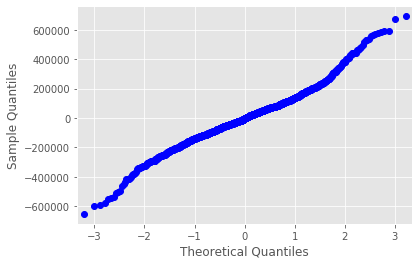

In [47]:
#2. check residual 
#2.1 Normality
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(mod_wls.resid)
print(JB,JBpv,skw,kurt)

sm.qqplot(mod_wls.resid)

plt.show()

Text(0.5, 1.0, 'Fitted Values vs. Residuals')

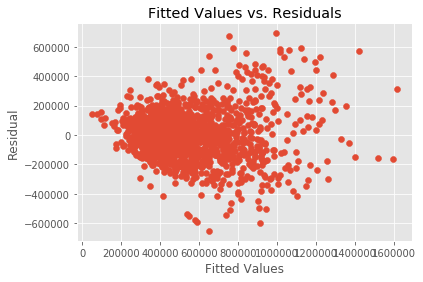

In [48]:
#2.2 Fitted Values vs. Residuals
p = mod_wls.fittedvalues.astype(int)
res = mod_wls.resid.astype(int)
# plt.scatter(p,res)
# plt.xlabel("Fitted Values")
# plt.ylabel("Residual")
# plt.title("Fitted Values vs. Residuals")

fig, ax = plt.subplots()
ax.scatter(p, res)
ax.ticklabel_format(style='plain')
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

### Best subet's best model

In [50]:
#fit for best sub (bedrooms, bathrooms, sqft_lot, view, condition, sqft_above, sqft_basement, built_age, renovated_age)
fit_best_sub = smf.ols('price~bedrooms+bathrooms+sqft_lot+view+condition+sqft_above+sqft_basement+built_age+renovated_age',data=housepriceC).fit()
fit_best_sub.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     313.8
Date:                Sun, 13 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:58:49   Log-Likelihood:                -20478.
No. Observations:                1526   AIC:                         4.098e+04
Df Residuals:                    1516   BIC:                         4.103e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.025e+05   2.81e+04     -3.641      0.000   -1.58e+05   -4.73e+04
bedrooms      -4.605e+04   5961.664     -7.724      0.000   -5.77e+04   -3.44e+04
bathrooms      4.388e+04   8915.182      4.922      0.000    2.64e+04    6.14e+04
sqft_lot        -15.1546      1.622     -9.341      0.000     -18.337     -11.972
view           5.662e+04   6043.432      9.369      0.000    4.48e+04    6.85e+04
condition      3.663e+04   7326.051      4.999      0.000    2.23e+04     5.1e+04
sqft_above      346.4916     11.448     30.268      0.000     324.037     368.946
sqft_basement   159.3758     12.935     12.322      0.000     134.004     184.748
built_age      1893.6752    161.877     11.698      0.000    1576.149    2211.201
renovated_age  -456.4847    159.330     -2.865      0.004    -769.015    -143.955
==============================================================================
Omnibus:                       77.780   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.959
Skew:                           0.235   Prob(JB):                     1.55e-46
Kurtosis:                       4.760   Cond. No.                     4.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

210.9590562703105 1.5517543701364188e-46 0.23482223836946634 4.759906194329448


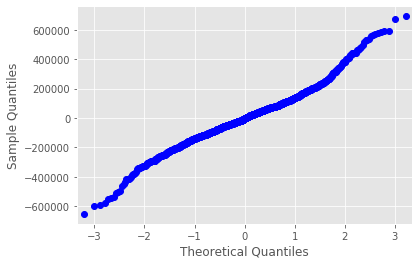

In [51]:
#2. check residual 
#2.1 Normality
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(fit_best_sub.resid)
print(JB,JBpv,skw,kurt)

sm.qqplot(fit_best_sub.resid)

plt.show()

In [52]:
#Breusch-Pagan for Heteroskedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
#from statsmodels.stats.diagnostic import het_white
#white_test = het_white(reg.resid,  reg.model.exog)
bp_test = het_breuschpagan(fit_best_sub.resid, fit_best_sub.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 245.69779101233493, 'LM-Test p-value': 8.072455576320515e-48, 'F-Statistic': 32.325514724390125, 'F-Test p-value': 2.8886096298138463e-52}


In [53]:
from statistics import mean 
# (fit12_new.resid).mean()
weight=(np.array(fit_best_sub.resid)-((fit_best_sub.resid).mean()))**2
weight=weight**(-1)
weight=list(weight)

In [54]:
#Exists Heteroskedasticity
#Weighted least squares
y = housepriceC['price']
X = housepriceC[['bedrooms', 'bathrooms', 'sqft_lot', 'view', 'condition', 'sqft_above', 'sqft_basement', 'built_age', 'renovated_age']]
X = sm.add_constant(X)
mod_wls_best_sub = sm.WLS(y, X, weight = weight).fit()
mod_wls_best_sub.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            WLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     313.8
Date:                Sun, 13 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:58:50   Log-Likelihood:                -20478.
No. Observations:                1526   AIC:                         4.098e+04
Df Residuals:                    1516   BIC:                         4.103e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.025e+05   2.81e+04     -3.641      0.000   -1.58e+05   -4.73e+04
bedrooms      -4.605e+04   5961.664     -7.724      0.000   -5.77e+04   -3.44e+04
bathrooms      4.388e+04   8915.182      4.922      0.000    2.64e+04    6.14e+04
sqft_lot        -15.1546      1.622     -9.341      0.000     -18.337     -11.972
view           5.662e+04   6043.432      9.369      0.000    4.48e+04    6.85e+04
condition      3.663e+04   7326.051      4.999      0.000    2.23e+04     5.1e+04
sqft_above      346.4916     11.448     30.268      0.000     324.037     368.946
sqft_basement   159.3758     12.935     12.322      0.000     134.004     184.748
built_age      1893.6752    161.877     11.698      0.000    1576.149    2211.201
renovated_age  -456.4847    159.330     -2.865      0.004    -769.015    -143.955
==============================================================================
Omnibus:                       77.780   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.959
Skew:                           0.235   Prob(JB):                     1.55e-46
Kurtosis:                       4.760   Cond. No.                     4.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
#Exists Heteroskedasticity
#Weighted least squares remove renovated_age
y = housepriceC['price']
X = housepriceC[['bedrooms', 'bathrooms', 'sqft_lot', 'view', 'condition', 'sqft_above', 'sqft_basement', 'built_age']]
X = sm.add_constant(X)
mod_wls_best_sub = sm.WLS(y, X).fit()
mod_wls_best_sub.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.649
Model:                            WLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     350.3
Date:                Sun, 13 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:58:50   Log-Likelihood:                -20483.
No. Observations:                1526   AIC:                         4.098e+04
Df Residuals:                    1517   BIC:                         4.103e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.589e+04   2.66e+04     -2.850      0.004   -1.28e+05   -2.37e+04
bedrooms      -4.568e+04   5974.423     -7.646      0.000   -5.74e+04    -3.4e+04
bathrooms      4.393e+04   8936.324      4.915      0.000    2.64e+04    6.15e+04
sqft_lot        -14.8730      1.623     -9.163      0.000     -18.057     -11.689
view           5.717e+04   6054.694      9.442      0.000    4.53e+04     6.9e+04
condition      2.662e+04   6454.833      4.124      0.000     1.4e+04    3.93e+04
sqft_above      344.8463     11.460     30.090      0.000     322.366     367.326
sqft_basement   160.0690     12.963     12.348      0.000     134.641     185.497
built_age      1755.8838    154.934     11.333      0.000    1451.976    2059.791
==============================================================================
Omnibus:                       77.272   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.155
Skew:                           0.237   Prob(JB):                     1.04e-45
Kurtosis:                       4.742   Cond. No.                     3.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

207.15500358149265 1.0395910284991924e-45 0.23716500397284343 4.741556477288555


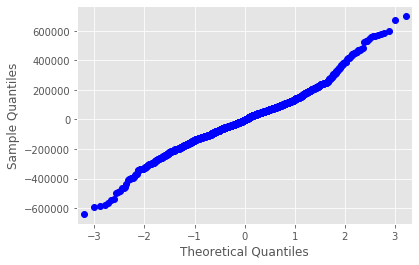

In [56]:
#2. check residual 
#2.1 Normality
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(mod_wls_best_sub.resid)
print(JB,JBpv,skw,kurt)

sm.qqplot(mod_wls_best_sub.resid)

plt.show()

Text(0.5, 1.0, 'Fitted Values vs. Residuals')

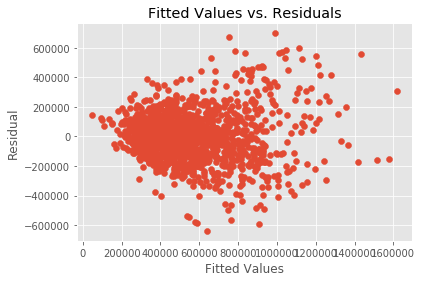

In [57]:
#2.2 Fitted Values vs. Residuals
p = mod_wls_best_sub.fittedvalues.astype(int)
res = mod_wls_best_sub.resid.astype(int)
# plt.scatter(p,res)
# plt.xlabel("Fitted Values")
# plt.ylabel("Residual")
# plt.title("Fitted Values vs. Residuals")

fig, ax = plt.subplots()
ax.scatter(p, res)
ax.ticklabel_format(style='plain')
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

In [59]:
#Anova table for wls
mod_wls_best_sub = wls('price~bedrooms+bathrooms+sqft_lot+view+condition+sqft_above+sqft_basement+built_age+renovated_age',data=housepriceC).fit()
print(anova_lm(mod_wls_best_sub, typ=2))

                     sum_sq      df           F         PR(>F)
bedrooms       1.593345e+12     1.0   59.663814   2.032460e-14
bathrooms      6.469620e+11     1.0   24.225904   9.502085e-07
sqft_lot       2.330345e+12     1.0   87.261265   3.277250e-20
view           2.344001e+12     1.0   87.772599   2.566627e-20
condition      6.674483e+11     1.0   24.993025   6.422482e-07
sqft_above     2.446544e+13     1.0  916.124119  8.238917e-158
sqft_basement  4.054410e+12     1.0  151.819970   2.570641e-33
built_age      3.654612e+12     1.0  136.849277   2.503745e-30
renovated_age  2.192088e+11     1.0    8.208414   4.227140e-03
Residual       4.048536e+13  1516.0         NaN            NaN


# Logistic regression

In [60]:
#Logistic regression part
housepriceC.loc[housepriceC.price>=485000.0, 'price_class'] = 1
housepriceC.loc[housepriceC.price<485000.0, 'price_class'] = 0
np.median(housepriceC.price)

485000.0

## Fit all predictors for full model

In [61]:
#Method I
#Logistics for the full model
formula3 = 'price_class~bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+sqft_above+sqft_basement+built_age+renovated_age'
model3 = smf.glm(formula = formula3, data=housepriceC, family=sm.families.Binomial())
result3 = model3.fit()
print(result3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            price_class   No. Observations:                 1526
Model:                            GLM   Df Residuals:                     1515
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -679.74
Date:                Sun, 13 Oct 2019   Deviance:                       1359.5
Time:                        23:58:51   Pearson chi2:                 1.58e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -7.1958      0.604    -11.909

In [62]:
#Logistic for model without the predictors which are not significant in the full model
formula4 = 'price_class~bedrooms+bathrooms+sqft_living+sqft_lot+waterfront+view+condition+sqft_above+built_age'
model4 = smf.glm(formula = formula4, data=housepriceC, family=sm.families.Binomial())
result4 = model4.fit()
print(result4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            price_class   No. Observations:                 1526
Model:                            GLM   Df Residuals:                     1517
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -682.44
Date:                Sun, 13 Oct 2019   Deviance:                       1364.9
Time:                        23:58:51   Pearson chi2:                 1.57e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -6.4405      0.495    -13.009      

In [63]:
print(result4.summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            1382.8847 
Link Function:      logit            BIC:            -9755.3400
Dependent Variable: price_class      Log-Likelihood: -682.44   
Date:               2019-10-13 23:58 LL-Null:        -1057.7   
No. Observations:   1526             Deviance:       1364.9    
Df Model:           8                Pearson chi2:   1.57e+03  
Df Residuals:       1517             Scale:          1.0000    
Method:             IRLS                                       
---------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      -6.4405   0.4951 -13.0086 0.0000 -7.4109 -5.4701
bedrooms       -0.3303   0.1035  -3.1921 0.0014 -0.5331 -0.1275
bathrooms       0.4865   0.1505   3.2318 0.0012  0.1914  0.7815
sqft_living     0.0018   0.0002   7.5510 0.0000  0.0013

In [64]:
#Logistic for model without the predictors which are not significant in the former model
formula5 = 'price_class~bedrooms+bathrooms+sqft_living+sqft_lot+view+condition+sqft_above+built_age'
model5 = smf.glm(formula = formula5, data=housepriceC, family=sm.families.Binomial())
result5 = model5.fit()
print(result5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            price_class   No. Observations:                 1526
Model:                            GLM   Df Residuals:                     1517
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -682.44
Date:                Sun, 13 Oct 2019   Deviance:                       1364.9
Time:                        23:58:51   Pearson chi2:                 1.57e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -6.4405      0.495    -13.009      

In [65]:
print(result5.summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            1382.8847 
Link Function:      logit            BIC:            -9755.3400
Dependent Variable: price_class      Log-Likelihood: -682.44   
Date:               2019-10-13 23:58 LL-Null:        -1057.7   
No. Observations:   1526             Deviance:       1364.9    
Df Model:           8                Pearson chi2:   1.57e+03  
Df Residuals:       1517             Scale:          1.0000    
Method:             IRLS                                       
---------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      -6.4405   0.4951 -13.0086 0.0000 -7.4109 -5.4701
bedrooms       -0.3303   0.1035  -3.1921 0.0014 -0.5331 -0.1275
bathrooms       0.4865   0.1505   3.2318 0.0012  0.1914  0.7815
sqft_living     0.0018   0.0002   7.5510 0.0000  0.0013

In [66]:
#Deviance test for Method I
#chi square a=0.05 df = 4  : 9.49
G = 1364.9-1359.5
G<9.49
#We fail to reject the null hypothesis.
#We will select the second model as our best model.

True

## With only selected predictors

In [67]:
#Method II
#Logistics regression with the predictor that we select for our OLS model
formula = 'price_class~bedrooms+bathrooms+sqft_lot+view+condition+sqft_above+sqft_basement+built_age+renovated_age'

In [68]:
model = smf.glm(formula = formula, data=housepriceC, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            price_class   No. Observations:                 1526
Model:                            GLM   Df Residuals:                     1516
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -681.27
Date:                Sun, 13 Oct 2019   Deviance:                       1362.5
Time:                        23:58:52   Pearson chi2:                 1.59e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.7001      0.528    -12.700

In [69]:
print(result.summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            1382.5490 
Link Function:      logit            BIC:            -9750.3453
Dependent Variable: price_class      Log-Likelihood: -681.27   
Date:               2019-10-13 23:58 LL-Null:        -1057.7   
No. Observations:   1526             Deviance:       1362.5    
Df Model:           9                Pearson chi2:   1.59e+03  
Df Residuals:       1516             Scale:          1.0000    
Method:             IRLS                                       
---------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      -6.7001   0.5276 -12.6997 0.0000 -7.7341 -5.6660
bedrooms       -0.3381   0.1038  -3.2583 0.0011 -0.5414 -0.1347
bathrooms       0.4923   0.1509   3.2616 0.0011  0.1965  0.7881
sqft_lot       -0.0002   0.0000  -7.4256 0.0000 -0.0003

Text(0.5, 1.0, 'predict point vs. Residuals')

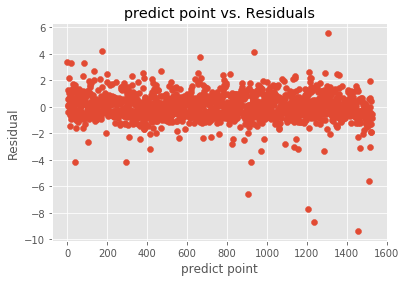

In [70]:
logi_res = result.resid_pearson
pre_num = list(range(housepriceC.shape[0]))
fig, ax = plt.subplots()
ax.scatter(pre_num, logi_res)
ax.ticklabel_format(style='plain')
plt.xlabel("predict point")
plt.ylabel("Residual")
plt.title("predict point vs. Residuals")

In [71]:
#Logistics regression without the predictor which is not significant in our former model
formula2 = 'price_class~bedrooms+bathrooms+sqft_lot+view+condition+sqft_above+sqft_basement+built_age'
model2 = smf.glm(formula = formula2, data=housepriceC, family=sm.families.Binomial())
result2 = model2.fit()
print(result2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            price_class   No. Observations:                 1526
Model:                            GLM   Df Residuals:                     1517
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -682.44
Date:                Sun, 13 Oct 2019   Deviance:                       1364.9
Time:                        23:58:52   Pearson chi2:                 1.57e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.4405      0.495    -13.009

In [72]:
print(result2.summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            1382.8847 
Link Function:      logit            BIC:            -9755.3400
Dependent Variable: price_class      Log-Likelihood: -682.44   
Date:               2019-10-13 23:58 LL-Null:        -1057.7   
No. Observations:   1526             Deviance:       1364.9    
Df Model:           8                Pearson chi2:   1.57e+03  
Df Residuals:       1517             Scale:          1.0000    
Method:             IRLS                                       
---------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      -6.4405   0.4951 -13.0086 0.0000 -7.4109 -5.4701
bedrooms       -0.3303   0.1035  -3.1921 0.0014 -0.5331 -0.1275
bathrooms       0.4865   0.1505   3.2318 0.0012  0.1914  0.7815
sqft_lot       -0.0002   0.0000  -7.3270 0.0000 -0.0003

In [73]:
logi_res2 = result2.resid_pearson
pre_num = list(range(housepriceC.shape[0]))

Text(0.5, 1.0, 'predict point vs. Residuals')

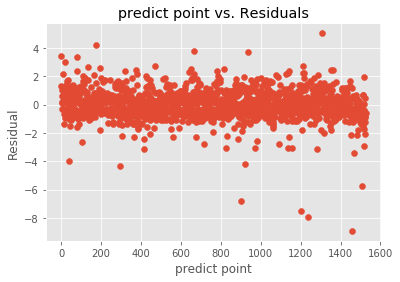

In [74]:
fig, ax = plt.subplots()
ax.scatter(pre_num, logi_res2)
ax.ticklabel_format(style='plain')
plt.xlabel("predict point")
plt.ylabel("Residual")
plt.title("predict point vs. Residuals")


In [75]:
#Pred accuracy for Method II
predictions5 = result5.predict()
housepriceC['pred_logi_5'] = predictions5
housepriceC.loc[housepriceC.pred_logi_5>=0.5, 'pred_price_class_5'] =1
housepriceC.loc[housepriceC.pred_logi_5<0.5, 'pred_price_class_5'] =0
housepriceC.loc[housepriceC.price_class == housepriceC.pred_price_class_5].shape[0]/housepriceC.shape[0]

0.7896461336828309

In [76]:
#Deviance test for Method II
#chi square a=0.05 df = 1  : 3.84
G = 1364.9-1362.5
G<3.84
#We fail to reject the null hypothesis.
#We will select the second model as our best model.

True

In [77]:
#Pred accuracy for Method II
predictions = result2.predict()
housepriceC['pred_logi'] = predictions
housepriceC.loc[housepriceC.pred_logi>=0.5, 'pred_price_class'] =1
housepriceC.loc[housepriceC.pred_logi<0.5, 'pred_price_class'] =0
housepriceC.loc[housepriceC.price_class == housepriceC.pred_price_class].shape[0]/housepriceC.shape[0]

0.7896461336828309